In [15]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from typing import Tuple

In [23]:
def load_data(data_path: str) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
	"""
	데이터 로드 함수. 지정된 경로에서 데이터를 읽어옵니다.

	Args:
		data_path (str): 데이터 파일들이 저장된 디렉토리 경로.

	Returns:
		Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame]:
			- 사용자-아이템 상호작용 데이터 (train_ratings.csv)
			- 영화 제목 데이터 (titles.tsv)
			- 영화 개봉 연도 데이터 (years.tsv)
			- 영화 감독 데이터 (directors.tsv)
			- 영화 장르 데이터 (genres.tsv)
			- 영화 작가 데이터 (writers.tsv)
	"""
	# 사용자-아이템 상호작용 데이터 로드
	train_rating = pd.read_csv(os.path.join(data_path, "train_ratings.csv"))

	# 영화 제목 데이터 로드
	title = pd.read_csv(os.path.join(data_path, "titles.tsv"), sep='\t')

	# 영화 개봉 연도 데이터 로드
	year = pd.read_csv(os.path.join(data_path, "years.tsv"), sep='\t')

	# 영화 감독 데이터 로드
	director = pd.read_csv(os.path.join(data_path, "directors.tsv"), sep='\t')

	# 영화 장르 데이터 로드
	genre = pd.read_csv(os.path.join(data_path, "genres.tsv"), sep='\t')

	# 영화 작가 데이터 로드
	writer = pd.read_csv(os.path.join(data_path, "writers.tsv"), sep='\t')

	return train_rating, title, year, director, genre, writer

In [55]:
def preprocess_genres(genres: pd.DataFrame) -> pd.DataFrame:
	"""
	영화별 장르 데이터를 하나의 행으로 병합합니다.

	Args:
		genres (pd.DataFrame): 분리된 장르 데이터.

	Returns:
		pd.DataFrame: 병합된 장르 데이터.
	"""
	merged_genres = genres.groupby("item")["genre"].apply(",".join).reset_index()
	return merged_genres

In [60]:
def preprocess_writers(writers: pd.DataFrame) -> pd.DataFrame:
	"""
	영화별 장르 데이터를 하나의 행으로 병합합니다.

	Args:
		genres (pd.DataFrame): 분리된 장르 데이터.

	Returns:
		pd.DataFrame: 병합된 장르 데이터.
	"""
	merged_writers = writers.groupby("item")["writer"].apply(",".join).reset_index()
	return merged_writers

In [64]:
def preprocess_directors(directors: pd.DataFrame) -> pd.DataFrame:
	"""
	영화별 장르 데이터를 하나의 행으로 병합합니다.

	Args:
		genres (pd.DataFrame): 분리된 장르 데이터.

	Returns:
		pd.DataFrame: 병합된 장르 데이터.
	"""
	merged_directors = directors.groupby("item")["director"].apply(",".join).reset_index()
	return merged_directors

In [71]:
def preprocess_data(ratings: pd.DataFrame, genres: pd.DataFrame, directors: pd.DataFrame, writers: pd.DataFrame, years: pd.DataFrame) -> pd.DataFrame:
	"""
	사용자-아이템 데이터와 메타데이터를 결합합니다.

	Args:
		ratings (pd.DataFrame): 사용자-아이템 상호작용 데이터.
		genres (pd.DataFrame): 장르 데이터.
		directors (pd.DataFrame): 감독 데이터.
		writers (pd.DataFrame): 작가 데이터.
		years (pd.DataFrame): 개봉 연도 데이터.

	Returns:
		pd.DataFrame: 결합된 데이터.
	"""
	# 장르 병합
	merged_genres = preprocess_genres(genres)
	merged_writers = preprocess_writers(writers)
	merged_directors = preprocess_directors(directors)

	# 사용자-아이템 데이터와 장르 데이터 병합
	data = ratings.merge(merged_genres, on="item", how="left")
	data = data.merge(merged_directors, on="item", how="left")
	data = data.merge(merged_writers, on="item", how="left")
	data = data.merge(years, on="item", how="left")

	# 시간 순서로 정렬
	data["time"] = pd.to_datetime(data["time"], unit="s")
	data = data.sort_values(by=["user", "time"])
	return data

In [66]:
from pandarallel import pandarallel

# Pandarallel 초기화
pandarallel.initialize(progress_bar=True)

def calculate_similarity_optimized(data: pd.DataFrame) -> pd.DataFrame:
	"""
	연속적인 영화 선택 간 공통점을 병렬 처리로 계산합니다.

	Args:
		data (pd.DataFrame): 사용자-아이템 및 메타데이터 결합 데이터.

	Returns:
		pd.DataFrame: 사용자-아이템 간 공통점 계산 결과.
	"""
	data["next_item"] = data.groupby("user")["item"].shift(-1)
	data["next_genre"] = data.groupby("user")["genre"].shift(-1)
	data["next_director"] = data.groupby("user")["director"].shift(-1)
	data["next_writer"] = data.groupby("user")["writer"].shift(-1)
	data["next_year"] = data.groupby("user")["year"].shift(-1)

	# 공통점 계산 병렬 처리
	data["common_genres"] = data.parallel_apply(
		lambda row: len(set(str(row["genre"]).split(",")).intersection(set(str(row["next_genre"]).split(",")))),
		axis=1,
	)
	data["same_director"] = data["director"] == data["next_director"]
	data["same_writer"] = data["writer"] == data["next_writer"]
	data["same_year"] = data["year"] == data["next_year"]

	# 결과 필터링
	return data.dropna(subset=["next_item"])[
		["user", "item", "next_item", "common_genres", "same_director", "same_writer", "same_year"]
	]

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [67]:
def analyze_similarity(similarity_data: pd.DataFrame) -> None:
	"""
	공통점 분석 결과를 시각화합니다.

	Args:
		similarity_data (pd.DataFrame): 사용자-아이템 간 공통점 데이터.
	"""
	print("Average number of common genres:", similarity_data["common_genres"].mean())
	print("Proportion of same director:", similarity_data["same_director"].mean())
	print("Proportion of same writer:", similarity_data["same_writer"].mean())
	print("Proportion of same year:", similarity_data["same_year"].mean())

In [68]:
if __name__ == "__main__":
	# 데이터 경로 설정
	data_path = "/data/ephemeral/home/kim/level2-recsys-movierecommendation-recsys-08-lv3/data/train/"

	# 데이터 로드 및 전처리
	ratings, title, year, director, genre, writer = load_data(data_path)
	merged_data = preprocess_data(ratings, genre, director, writer, year)

	# tqdm 또는 verbose 버전으로 진행률 확인
	similarity_data = calculate_similarity_optimized(merged_data)

	# 분석 및 결과 출력
	analyze_similarity(similarity_data)

Average number of common genres: 0.9312554422498361
Proportion of same director: 0.02606580259533709
Proportion of same writer: 0.011641754394936983
Proportion of same year: 0.08217038436215807


In [ ]:
merged_data.head()

,user,item,time,genre,director,writer,year,next_item,next_genre,next_director,next_writer,next_year,common_genres,same_director,same_writer,same_year
0,11,4643,2009-01-01 04:02:09,"Action,Adventure,Drama,Sci-Fi",nm0000318,"nm0099541,nm0115310,nm0465199,nm0742797",2001.0,170.0,"Action,Adventure,Crime,Thriller",nm0812200,NaN,1995.0,2,False,False,False
1,11,170,2009-01-01 04:02:14,"Action,Adventure,Crime,Thriller",nm0812200,NaN,1995.0,531.0,"Children,Drama",nm0002140,"nm0003031,nm0122364",1993.0,0,False,False,False
2,11,531,2009-01-01 04:02:19,"Children,Drama",nm0002140,"nm0003031,nm0122364",1993.0,616.0,"Animation,Children",nm0718627,"nm0027011,nm0166307,nm0166551,nm0314788,nm0841...",1970.0,1,False,False,False
3,11,616,2009-01-01 04:02:22,"Animation,Children",nm0718627,"nm0027011,nm0166307,nm0166551,nm0314788,nm0841...",1970.0,2140.0,"Adventure,Fantasy",nm0000568,"nm0001345,nm0643973",1982.0,0,False,False,False
4,11,2140,2009-01-01 04:02:43,"Adventure,Fantasy",nm0000568,"nm0001345,nm0643973",1982.0,2140.0,"Adventure,Fantasy",nm0001345,"nm0001345,nm0643973",1982.0,2,False,True,True


In [69]:
merged_data.shape

(5154471, 16)

In [84]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from pandarallel import pandarallel

# Pandarallel 초기화
pandarallel.initialize(progress_bar=True)

def calculate_tfidf_similarity_parallel(data: pd.DataFrame, title_data: pd.DataFrame) -> pd.DataFrame:
    """
    영화 제목 간 TF-IDF 기반 유사성을 병렬 처리로 계산합니다.

    Args:
        data (pd.DataFrame): 사용자-아이템 및 메타데이터 결합 데이터.
        title_data (pd.DataFrame): 영화 제목 데이터.

    Returns:
        pd.DataFrame: 사용자-아이템 간 제목 유사성 결과.
    """
    # 제목 데이터 병합
    data = data.merge(title_data, on="item", how="left", suffixes=("", "_current"))
    data["next_title"] = data.groupby("user")["title"].shift(-1)

    # 중복 제거한 제목 리스트 생성
    all_titles = pd.concat([data["title"], data["next_title"]]).dropna().unique()

    # TF-IDF 벡터화
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(all_titles)

    # 제목과 인덱스 매핑
    title_to_index = {title: idx for idx, title in enumerate(all_titles)}

    def compute_similarity(row):
        """
        개별 행에 대해 TF-IDF 유사성을 계산합니다.
        """
        if pd.isnull(row["next_title"]):
            return 0
        title_idx = title_to_index[row["title"]]
        next_title_idx = title_to_index[row["next_title"]]
        return cosine_similarity(tfidf_matrix[title_idx], tfidf_matrix[next_title_idx]).flatten()[0]

    # 병렬 처리로 유사성 계산
    data["title_similarity"] = data.parallel_apply(compute_similarity, axis=1)

    return data[["user", "item", "title", "next_title", "title_similarity"]].dropna()


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [85]:
if __name__ == "__main__":
    # 데이터 경로 설정
    data_path = "/data/ephemeral/home/kim/level2-recsys-movierecommendation-recsys-08-lv3/data/train/"

    # 데이터 로드 및 전처리
    ratings, title, year, director, genre, writer = load_data(data_path)
    merged_data = preprocess_data(ratings, genre, director, writer, year)

    # 제목 유사성 계산 (TF-IDF 기반)
    title_similarity_data = calculate_tfidf_similarity_parallel(merged_data, title)

    # 결과 확인
    print(title_similarity_data.head())
##


   user  item                      title                 next_title  \
0    11  4643  Planet of the Apes (2001)             Hackers (1995)   
1    11   170             Hackers (1995)  Secret Garden, The (1993)   
2    11   531  Secret Garden, The (1993)     Aristocats, The (1970)   
3    11   616     Aristocats, The (1970)   Dark Crystal, The (1982)   
4    11  2140   Dark Crystal, The (1982)       Deep Blue Sea (1999)   

   title_similarity  
0          0.000000  
1          0.000000  
2          0.034539  
3          0.033777  
4          0.000000  


In [86]:
import matplotlib.pyplot as plt

def plot_title_similarity_histogram(similarity_data: pd.DataFrame) -> None:
    """
    제목 유사성 분포를 히스토그램으로 시각화합니다.

    Args:
        similarity_data (pd.DataFrame): 제목 유사성을 포함한 데이터프레임.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(similarity_data["title_similarity"], bins=20, color="skyblue", edgecolor="black")
    plt.title("Title Similarity Distribution")
    plt.xlabel("Similarity Score")
    plt.ylabel("Frequency")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

In [87]:
def plot_title_similarity_boxplot(similarity_data: pd.DataFrame) -> None:
    """
    제목 유사성 분포를 박스플롯으로 시각화합니다.

    Args:
        similarity_data (pd.DataFrame): 제목 유사성을 포함한 데이터프레임.
    """
    plt.figure(figsize=(8, 6))
    plt.boxplot(similarity_data["title_similarity"], vert=False, patch_artist=True, boxprops=dict(facecolor="lightblue"))
    plt.title("Title Similarity Boxplot")
    plt.xlabel("Similarity Score")
    plt.show()

In [88]:
import seaborn as sns

def plot_title_similarity_kde(similarity_data: pd.DataFrame) -> None:
    """
    제목 유사성 분포를 KDE 플롯으로 시각화합니다.

    Args:
        similarity_data (pd.DataFrame): 제목 유사성을 포함한 데이터프레임.
    """
    plt.figure(figsize=(10, 6))
    sns.kdeplot(similarity_data["title_similarity"], shade=True, color="blue")
    plt.title("Title Similarity Distribution (KDE)")
    plt.xlabel("Similarity Score")
    plt.ylabel("Density")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

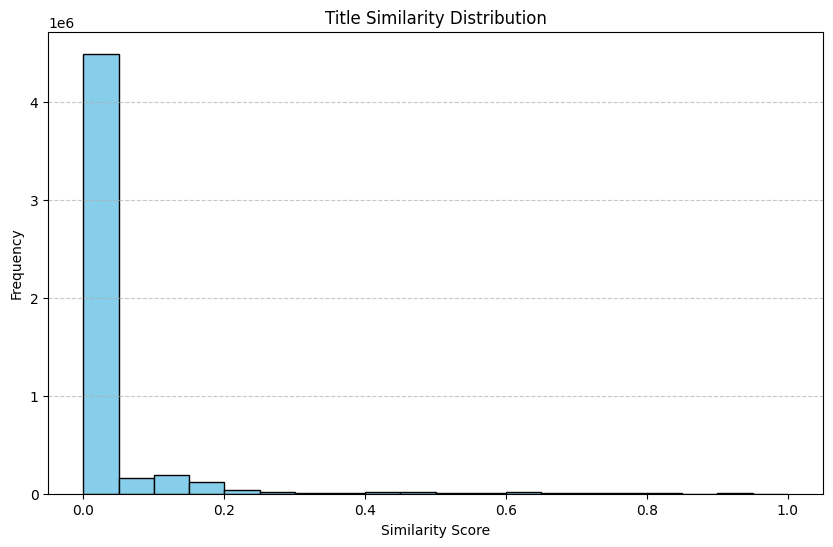

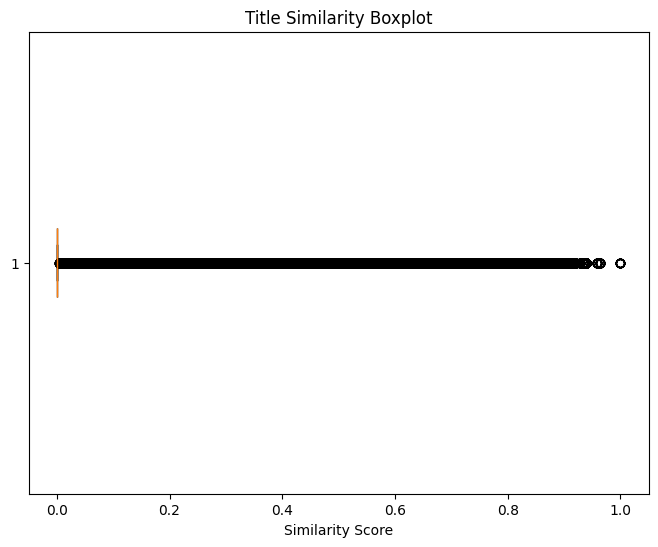

/tmp/ipykernel_383850/770692678.py:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(similarity_data["title_similarity"], shade=True, color="blue")


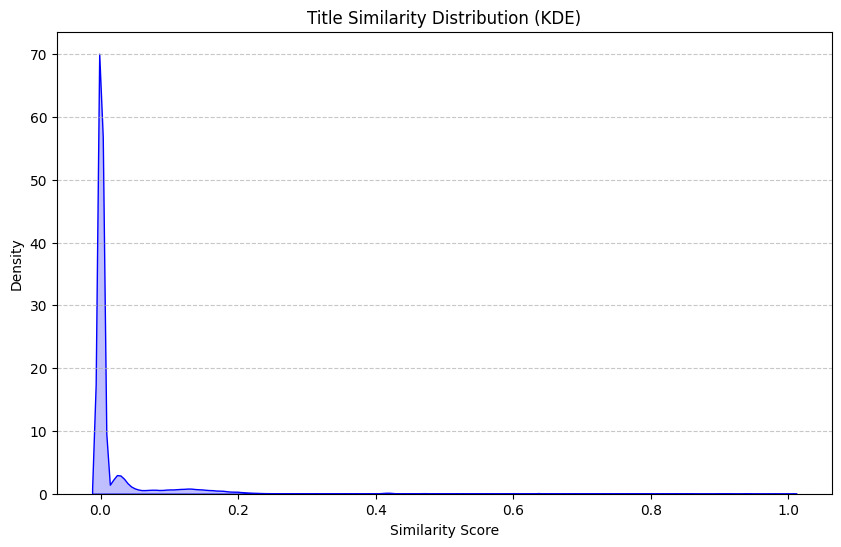

In [ ]:
# 히스토그램
plot_title_similarity_histogram(title_similarity_data)

# 박스플롯
plot_title_similarity_boxplot(title_similarity_data)

# KDE 플롯
plot_title_similarity_kde(title_similarity_data)

In [77]:
merged_data.head()

,user,item,time,genre,director,writer,year
0,11,4643,2009-01-01 04:02:09,"Action,Adventure,Drama,Sci-Fi",nm0000318,"nm0099541,nm0115310,nm0465199,nm0742797",2001.0
1,11,170,2009-01-01 04:02:14,"Action,Adventure,Crime,Thriller",nm0812200,NaN,1995.0
2,11,531,2009-01-01 04:02:19,"Children,Drama",nm0002140,"nm0003031,nm0122364",1993.0
3,11,616,2009-01-01 04:02:22,"Animation,Children",nm0718627,"nm0027011,nm0166307,nm0166551,nm0314788,nm0841...",1970.0
4,11,2140,2009-01-01 04:02:43,"Adventure,Fantasy","nm0000568,nm0001345","nm0001345,nm0643973",1982.0
